# Wrangling OpenStreetMap Data with SQL
# Map Area
Munich, Germany

OSM-data on munich: https://www.openstreetmap.org/export#map=11/48.1551/11.5418

Where I downloaded the actual file from: http://overpass-api.de/query_form.html

In [2]:
import xml.etree.cElementTree as ET
import pprint
from pprint import pprint
from collections import defaultdict
import re
import os
import csv
import codecs
import cerberus
import sqlite3
import pandas as pd

### Taking sample from OSM file

Method *get_element* gets elements with tags "node" and "way" and "relation"

For writing Sample-File take every k-th top level element

The provided code from the Project Details produced an error when running with python3: _"TypeError: a bytes-like object is required, not 'str'"_<br>
Adding "b'" in the write statement worked for me

In [2]:
#creating systematic sample elements from original OSM-file (!Ref. "Project Details"!)

#import xml.etree.ElementTree as ET  # Use cElementTree or lxml if too slow

OSM_FILE = "OSM_munich.osm"  # Replace this with your osm file
SAMPLE_FILE = "sample_file_munich.osm"

k = 6 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag
    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write(b'<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write(b'<osm>\n  ')
    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))
    
    output.write(b'</osm>')

Check sizes of OSM- and Sample-Files:

In [3]:
#resource: http://stackoverflow.com/questions/2104080/how-to-check-file-size-in-python

def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)

In [4]:
#check size of sample file

OSM_size = file_size(OSM_FILE)
sample_size = file_size(SAMPLE_FILE)

print ('OSM File Size', OSM_size)
print ('Sample File Size', sample_size)

OSM File Size 313.6 MB
Sample File Size 51.7 MB


### Screening OSM-file
Due to size of OSM-file I was only able to do screening on the sample file. Iterparsing the full OSM-file took way too long on my machine.
#### Unique users
We want to find out how many unique users have contributed to the map in this particular area. The function *process_map* returns a set of unique user IDs ("uid")

In [5]:
#getting unique users (!Ref. "Case Study - Exploring Users"!)

def get_user(element):
    uid = ''
    if element.tag == "node" or element.tag == "way" or element.tag == "relation":
        uid = element.get('uid')
    return uid


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        if get_user(element):
            users.add(get_user(element))
            users.discard('')
        pass

    return users

users = process_map(SAMPLE_FILE)  # Using Sample file as input
print ('UNIQUE USERS: ', len(users))

UNIQUE USERS:  3294


#### Counting element tags

We use the iterative parsing to process the map file and find out not only what tags are there, but also how many, to get the feeling on how much of which data we can expect to have in the map.

In [6]:
# Counting the element tags in the file (!Ref. Case Study - Iterative Parsing!)

def count_tags(filename):
    tags = {}
    for event,elem in ET.iterparse(filename, events=("start",)):
        if elem.tag in tags.keys():
            tags[elem.tag] += 1
        else:
            tags[elem.tag] = 1
    return tags    
    
tags = count_tags(SAMPLE_FILE)  # Using Sample file as input
pprint(tags)

{'member': 24282,
 'nd': 278994,
 'node': 210781,
 'osm': 1,
 'relation': 633,
 'tag': 194004,
 'way': 38068}


#### Element sub tags

Sub tags are child elements of elements like e.g. nodes, ways and relations, and consist of two attributes, a key 'k' and a value 'v', that describe the meaning of the particular element.

Before we process the data and add it into our database, we check the
"k" value for each "<tag>" and see if there are any potential problems.

The function 'key_type' counts each of four tag categories:
"lower", for tags that contain only lowercase letters and are valid,
"lower_colon", for otherwise valid tags with a colon in their names,
"problemchars", for tags with problematic characters, and
"other", for other tags that do not fall into the other three categories.

In [7]:
# Finding out formatting scheme of K attribute in tags (!Ref. "Case study OSM - Tag Types"!)

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

keys = defaultdict(int)

def key_count(keys, element):
    if element.tag == 'tag':
        keys[element.attrib['k']] += 1
    return keys

def key_type(element, key_categories):
    if element.tag == "tag":
        if lower.match(element.attrib['k']):
            key_categories["lower"] += 1
        elif lower_colon.search(element.attrib['k']):
            key_categories["lower_colon"] += 1
        elif problemchars.search(element.attrib['k']):
            key_categories["problemchars"] += 1
        else:
            key_categories["other"] += 1
        pass
        
    return key_categories

def process_key_map(filename):
    key_categories = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        key_categories = key_type(element, key_categories)
        key_count(keys, element)

    return key_categories

key_categories = process_key_map(SAMPLE_FILE)
pprint(key_categories)

{'lower': 108611, 'lower_colon': 83824, 'other': 1568, 'problemchars': 1}


There is 1 problematic character in our sample file

In the keys dictionary we collect the unique keys. 'key_count' counts the number of occurances of each key.

'filter_count_tags' filters and sorts 'keys' for better visibility.

In [8]:
def filter_count_tags(d, threshold=100):
    l1 = []
    for key in d:
        if d[key] > threshold:
            l1.append((key, d[key]))
    l1.sort(key=lambda tup: tup[1], reverse= True)
    return l1

filter_count_tags(keys)

[('building', 20014),
 ('addr:street', 15268),
 ('addr:housenumber', 15258),
 ('highway', 12810),
 ('addr:city', 12039),
 ('addr:postcode', 12010),
 ('addr:country', 9761),
 ('name', 5799),
 ('surface', 4976),
 ('source', 4348),
 ('natural', 3347),
 ('roof:shape', 3293),
 ('building:levels', 3235),
 ('amenity', 2916),
 ('lit', 2266),
 ('maxspeed', 2042),
 ('service', 2021),
 ('landuse', 1961),
 ('bicycle', 1936),
 ('access', 1902),
 ('ref', 1678),
 ('foot', 1655),
 ('roof:levels', 1546),
 ('barrier', 1326),
 ('operator', 1270),
 ('tracktype', 1268),
 ('entrance', 1201),
 ('smoothness', 1174),
 ('roof:colour', 1151),
 ('wheelchair', 1072),
 ('level', 953),
 ('oneway', 842),
 ('addr:suburb', 814),
 ('layer', 809),
 ('lanes', 786),
 ('power', 738),
 ('emergency', 707),
 ('opening_hours', 705),
 ('building:colour', 695),
 ('railway', 691),
 ('website', 683),
 ('public_transport', 663),
 ('type', 642),
 ('leisure', 616),
 ('fire_hydrant:type', 605),
 ('leaf_type', 569),
 ('shop', 552),
 ('t

### Audit data

#### Audit phone numbers

Phone numbers are matched against a standard pattern. The standard internation phone number format is <country code> <3 digit area code> <6-8 digit number>. For Germany the country code is +49.
(Ref.: https://wiki.openstreetmap.org/wiki/DE:Key:phone)

In [9]:
phone_re = re.compile(r'^\+49\s\d{3}\s\d{6,8}$')

def audit_phone(phone_types, number):
    good_format = phone_re.search(number)
    if not good_format:
        phone_types.add(number)


def is_phone_number(elem):
    return (elem.attrib['k'] == 'phone')

#### Audit post codes

Post codes are matched against a 5-digit standard and the official list of post codes published by the city of Munich. 
(Ref.: https://www.muenchen.de/int/en/living/postal-codes.html)

In [10]:
postcode_re = re.compile(r'^\d{5}$')


# https://www.muenchen.de/int/en/living/postal-codes.html
expected = ['80995', '80997', '80999', '81247', '81249', '80331', '80333', '80335', '80336', '80469', '80538', '80539', 
            '81541', '81543', '81667', '81669', '81671', '81675', '81677', '81243', '81245', '81249', '81671', '81673', 
            '81735', '81825', '81675', '81677', '81679', '81925', '81927', '81929', '80933', '80935', '80995', '80689', 
            '81375', '81377', '80686', '80687', '80689', '80335', '80336', '80337', '80469', '80333', '80335', '80539', 
            '80636', '80797', '80798', '80799', '80801', '80802', '80807', '80809', '80937', '80939', '80637', '80638', 
            '80992', '80993', '80997', '80634', '80636', '80637', '80638', '80639', '81539', '81541', '81547', '81549', 
            '80687', '80689', '81241', '81243', '81245', '81247', '81539', '81549', '81669', '81671', '81735', '81737', 
            '81739', '80538', '80801', '80802', '80803', '80804', '80805', '80807', '80939', '80796', '80797', '80798', 
            '80799', '80801', '80803', '80804', '80809', '80335', '80339', '80336', '80337', '80469', '81369', '81371', 
            '81373', '81379', '80686', '81369', '81373', '81377', '81379', '81379', '81475', '81476', '81477', '81479', 
            '81735', '81825', '81827', '81829', '81543', '81545', '81547']

def audit_postcode(bad_postcodes, postcode):
    m = postcode_re.search(postcode)
    if m:
        postcode = m.group()
        if postcode not in expected:
            bad_postcodes[postcode] +=1
    else:
        bad_postcodes[postcode] +=1


def is_postcode(elem):
    return (elem.attrib['k'] == 'addr:postcode')

#### Audit street types

Street names are checked against a regular expression containing common street types

In [11]:
pattern = r'''
^(Am\b|Auf\sdem\b|Auf\sder\b|Im\b|In\sder\b|An\b|Zum\b|Zur\b)|
(straße|\bStraße|-Straße|\bWeg|weg|-Weg|platz|-Platz|\bPlatz|gasse|
\bRing|ring|\bHof|hof|\bAllee|-Allee|allee|wall|\bWall|markt|gürtel|feld)$'''

street_type_re = re.compile(pattern, re.VERBOSE)


# Count occurences for each street type
def count_street_type(street_type_count, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_type_count[street_type] +=1
    else:
        street_type_count[street_name] +=1


# Group streets by type
def group_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        street_types[street_type].add(street_name)
    else:
        street_types[street_name].add(street_name)

# Sorts the count of street types in descending order
def sort_values(street_type_count):
    sorted_counts = []
    d_view = [(v,k) for k,v in street_type_count.items()]
    d_view.sort(reverse=True) # natively sort tuples by first element
    for v,k in d_view:
        sorted_counts.append("%s: %d" % (k,v))
    return sorted_counts


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


In [12]:
# perform all of the above audits on the file
def audit(osmfile):

    phone_types = set()
    bad_postcodes = defaultdict(int)
    street_type_count = defaultdict(int)
    street_types = defaultdict(set)
    
    for event, elem in ET.iterparse(osmfile, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    count_street_type(street_type_count, tag.attrib['v'])
                    group_street_type(street_types, tag.attrib['v'])
                if is_phone_number(tag):
                    audit_phone(phone_types,tag.attrib['v'])
                if is_postcode(tag):
                    audit_postcode(bad_postcodes, tag.attrib['v'])

    street_type_count = sort_values(street_type_count)

    return phone_types, street_type_count, street_types, bad_postcodes

pprint(audit(SAMPLE_FILE))

({'+ 89 28778077',
  '+49 (0) 1511/4174698',
  '+49 (0) 89 / 72656937',
  '+49 (0) 89 21 99 89 42',
  '+49 (0) 89/31 78 29-0',
  '+49 (0) 89/931416',
  '+49 (0)8151 651780',
  '+49 (0)89 24415690',
  '+49 (0)89 89998242',
  '+49 (0)89-898676-0',
  '+49 (8141) 227722',
  '+49 (89) 52 01 13 60',
  '+49 (89) 545 7 4140',
  '+49 170 81 78 069',
  '+49 173 87 98 504',
  '+49 173 948 32 66',
  '+49 176 6666 8818',
  '+49 176 706 63 668',
  '+49 800 344226622',
  '+49 8024 93232',
  '+49 8025 999982',
  '+49 8027 585',
  '+49 8063 97030',
  '+49 8093 4055',
  '+49 8095 5369950',
  '+49 8102 748400',
  '+49 8104 629923',
  '+49 8105 22100',
  '+49 8105 7304149',
  '+49 8106 29555',
  '+49 8106 306 22 55',
  '+49 8106 32028',
  '+49 8106 38426',
  '+49 811 96313',
  '+49 8121 44102',
  '+49 8121 79598',
  '+49 8121 80617',
  '+49 8121 987731',
  '+49 8121 9880',
  '+49 8123 1432',
  '+49 8123 1442',
  '+49 8123 8757',
  '+49 8123 989 310',
  '+49 8131 53 91 88',
  '+49 8135 9914-0',
  '+49 8137

                       'Sankt-Margareten-Weg',
                       'Sankt-Rita-Weg',
                       'Sankt-Stephan-Weg',
                       'Sebastian-Pöttinger-Weg',
                       'Seidl-Kreuz-Weg',
                       'Sep-Ruf-Weg',
                       'St.-Emmeram-Weg',
                       'St.-Georg-Weg',
                       'St.-Korbinian-Weg',
                       'St.-Ulrichs-Weg',
                       'St.-Valentins-Weg',
                       'Sulzer-Belchen-Weg',
                       'Theo-Prosel-Weg',
                       'Von-Kobell-Weg',
                       'Von-Schöpf-Weg',
                       'Von-Taube-Weg',
                       'Walther-Klemm-Weg',
                       'Werner-Heisenberg-Weg',
                       'Wilhelm-Dieß-Weg',
                       'Willy-Teufelhart-Weg',
                       'Wolf-Ferrari-Weg',
                       'Wolf-Huber-Weg',
                       'Xaver-Hamberger-Weg'},
    

                         'Hochmuttinger Straße',
                         'Hochstadter Straße',
                         'Hofener Straße',
                         'Hofer Straße',
                         'Hoflacher Straße',
                         'Hofoldinger Straße',
                         'Hohenaschauer Straße',
                         'Hohenbrunner Straße',
                         'Hohenlindener Straße',
                         'Hohenlindner Straße',
                         'Hohensalzaer Straße',
                         'Holzapfelkreuther Straße',
                         'Holzkirchener Straße',
                         'Holzkirchner Straße',
                         'Humbacher Straße',
                         'Höglwörther Straße',
                         'Höhenkirchener Straße',
                         'Höhenkirchner Straße',
                         'Höhenstadter Straße',
                         'Immenstadter Straße',
                         'Indersdorfer Straße',
 

                         'Bauweberstraße',
                         'Bavariastraße',
                         'Bayersdorferstraße',
                         'Bayerstraße',
                         'Bayerwaldstraße',
                         'Bazeillesstraße',
                         'Beblostraße',
                         'Bechtolsheimstraße',
                         'Beckerstraße',
                         'Beckmesserstraße',
                         'Beethovenstraße',
                         'Behamstraße',
                         'Behringstraße',
                         'Beinhoferstraße',
                         'Beiselestraße',
                         'Beislerstraße',
                         'Belfaststraße',
                         'Belfortstraße',
                         'Bellinzonastraße',
                         'Benderstraße',
                         'Benediktbeuernstraße',
                         'Benediktenwandstraße',
                         'Benedikterstraße',


                         'Mühlenstraße',
                         'Mühlfeldstraße',
                         'Mühlstraße',
                         'Müllerstraße',
                         'Naagerstraße',
                         'Nadistraße',
                         'Naglerstraße',
                         'Nailastraße',
                         'Nandostraße',
                         'Narzissenstraße',
                         'Nauestraße',
                         'Naumannstraße',
                         'Naupliastraße',
                         'Nawiaskystraße',
                         'Naßlstraße',
                         'Neandertalstraße',
                         'Nebelhornstraße',
                         'Neckarstraße',
                         'Neherstraße',
                         'Neideckstraße',
                         'Neithardtstraße',
                         'Nelkenstraße',
                         'Nerbstraße',
                         'Nestroystraße',
        

                      'Bahnhofweg',
                      'Bahnweg',
                      'Bajuwarenweg',
                      'Baldusweg',
                      'Bannzaunweg',
                      'Barbaraweg',
                      'Barbenweg',
                      'Bastianweg',
                      'Bauernweg',
                      'Beethovenweg',
                      'Begasweg',
                      'Beiweg',
                      'Bekassinenweg',
                      'Benediktenweg',
                      'Berchardweg',
                      'Bergasternweg',
                      'Berghammerweg',
                      'Bergkieferweg',
                      'Bergweg',
                      'Bergwiesenweg',
                      'Bernsteinweg',
                      'Betzenweg',
                      'Biberweg',
                      'Bifangweg',
                      'Bildäckerweg',
                      'Birkenweg',
                      'Birketweg',
                     

#### Dirty data

Phone numbers: There are several wrong formats like e.g. '+49 (0) 89/35063630'. This phone number contains "(0)" which is not intended and a slash which is also wrong. Correct would be '+49 89 35063630'
Many others also contain dashes, e.g.'+49 (0)89-898676-0'

Postal codes: There are quite many post codes (103) which according to "https://www.muenchen.de/int/en/living/postal-codes.html" do not belong to the actual city of munich but surrounding cities.

Street names: No real problems were found in street names. Although there are several cases of 'straße', 'Straße' and '-Straße' this is not a case of inconsistency but represent the actual valid naming.

### Data Cleaning

#### Phone numbers:

In [13]:
# ================================================== #
#               Cleaning Functions                   #
# ================================================== #

def update_phone(phone_num):
  '''
  checks if a phone number matches the desired pattern, and if not, updates the phone number
  to the correct pattern
  Args: phone_num(string): phone number to be checked
  Returns:
    string: phone number with correct pattern
    None if phone number still does not match the pattern after a series of correcting steps 
  '''
  m = phone_re.search(phone_num)
  if not m:
    # remove all dashes
    if '-' in phone_num:
      phone_num = re.sub('-', '', phone_num)
    # remove all brackets
    if '(' in phone_num or ')' in phone_num:
      phone_num = re.sub('[()]', '', phone_num)
    # remove all slashes
    if '/' in phone_num:
      phone_num = re.sub('/','',phone_num)
    # remove all spaces
    if ' ' in phone_num:
      phone_num = re.sub(' ','', phone_num)
    # insert + sign if needed
    if re.match(r'49', phone_num):
      phone_num = '+' + phone_num
    # insert country code if needed
    if re.match(r'\w+', phone_num):
      phone_num = '+49' + phone_num
    # remove 0 from regional code
    if re.search(r'^\+490', phone_num):
      p = re.search(r'^(\+49)(0)', phone_num)
      phone_num = re.sub(r'^\+49(0)', p.group(1), phone_num)
    # insert space after country code and regional code
    if re.match(r'^(\+49)([1-9]\d{2})', phone_num):
      p = re.compile(r'(\+49)([1-9]\d{2})')
      phone_num = p.sub(r'\1 \2 ', phone_num)
    # exclude all numbers that after all the above corrections still do not match the desired pattern
    # this will correct for number lenghth (too long or too short) and for special characters such as ';' or ',' or '#'
    if re.search(r'^\+49\s\d{3}\s(\d{6,8})$', phone_num) is None:
      return
    
  return  phone_num

#### Preparing for Database

In [14]:
#(!Ref. "Case Study - Preparing for Database - SQL"!)

import schema
schema_file = open("my_schema.py")
from my_schema import schema

OSM_PATH = SAMPLE_FILE

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
# Regex to match phone numbers with correct format
phone_re = re.compile(r'^\+49\s\d{3}\s\d{6,8}$')
# Regex to match correct postcode format
postcode_re = re.compile(r'^\d{5}$')

SCHEMA = schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

#### Cleaning Functions

#### Post codes:

Postcodes which did not match any of the postcode values associated with Munich were skipped, i.e., incorrect postcodes were not exported to the csv files and therefore not imported to the database. If the postcode did not match the regular expression r'^\d{5}$', it was skipped . If it matched the regular expression but it was not one of the postcodes associated with Munich, then the whole element associated with that postcode was skipped. These cleaning steps are performed in the shape_element function.

In [15]:
# ================================================== #
#               Cleaning Functions                   #
# ================================================== #

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements
    
    if element.tag == 'node':
        # creating the dictionary for the node key
        for item in node_attr_fields:
            node_attribs[item] = element.attrib[item]
        # create the list of dictionaries for the node_tags key
        for tag in element.findall('tag'):
            entry = {}
            entry['id'] = node_attribs['id']
            if tag.attrib['k'] == 'phone' or tag.attrib['k'] == 'contact:phone':
              result = update_phone(tag.attrib['v'])
              if result:
                entry['value'] = result
              else:
                continue
            elif tag.attrib['k'] == 'addr:postcode':
              m = postcode_re.search(tag.attrib['v'])
              if m:
                postcode = m.group()
                if postcode not in expected:
                  # remove all elements associated with this postcode
                  return
                else:
                  entry['value'] = tag.attrib['v']
              else:
                # remove postcode tags that do not match regex
                continue
                  

            else:
              entry['value'] = tag.attrib['v']

            # get the match objects for problem and colon characters
            m = problem_chars.search(tag.attrib['k'])
            t = LOWER_COLON.search(tag.attrib['k'])
            # check if it has problem characters
            if m:
              return
            # check if there are colons in the value of k
            elif t:
              entry['key'] = tag.attrib['k'].split(':',1)[1]
              entry['type'] = tag.attrib['k'].split(':',1)[0]
            else:
              entry['key'] = tag.attrib['k']
              entry['type'] = default_tag_type
                

            
            tags.append(entry)
            
    if element.tag == 'way':
        # creating the dictionary for the way key
        for item in way_attr_fields:
            way_attribs[item] = element.attrib[item]
        # create the list of dictionaries for the way_tags key
        for tag in element.findall('tag'):
            entry = {}
            entry['id'] = way_attribs['id']
            if tag.attrib['k'] == 'phone' or tag.attrib['k'] == 'contact:phone':
              result = update_phone(tag.attrib['v'])
              if result:
                entry['value'] = result
              else:
                continue
            elif tag.attrib['k'] == 'addr:postcode':
              m = postcode_re.search(tag.attrib['v'])
              if m:
                postcode = m.group()
                if postcode not in expected:
                  # remove all elements associated with this postcode
                  return
                else:
                  entry['value'] = tag.attrib['v']
              else:
                # remove postcode tags that do not match regex
                continue
            else:
              entry['value'] = tag.attrib['v']

            # get the match objects for problem and colon characters
            m = problem_chars.search(tag.attrib['k'])
            t = LOWER_COLON.search(tag.attrib['k'])
            # check if it has problem characters
            if m:
              return
            # check if there are colons in the value of k
            elif t:
              entry['key'] = tag.attrib['k'].split(':',1)[1]
              entry['type'] = tag.attrib['k'].split(':',1)[0]
            else:
              entry['key'] = tag.attrib['k']
              entry['type'] = default_tag_type
            
            tags.append(entry)
        # create the list of dictionaries for way_nodes   
        count = 0
        for nd in element.findall('nd'):
            entry = {}
            entry['id'] = way_attribs['id']
            entry['node_id'] = nd.attrib['ref']
            entry['position'] = count
            count = count + 1
            
            way_nodes.append(entry)

            
    
       
    if element.tag == 'node':
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

#### Preparing for Database - SQL

After auditing is complete the next step is to prepare the data to be inserted into a SQL database.
To do so we will transform the elements in the OSM XML file from document format to
tabular format, thus making it possible to write to .csv files.  These csv files can then easily be
imported to a SQL database as tables.
The process for this transformation is as follows:
- Use iterparse to iteratively step through each top level element in the XML
- Shape each element into several data structures using a custom function
- Utilize a schema (my_schema.py) and validation library (cerberus) to ensure the transformed data is in the correct format
- Write each data structure to the appropriate .csv files

In [16]:
# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors), 'element =', element
        
        raise Exception(message_string.format(field, error_string))

### Write CSV-Files

In [17]:
# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    nodes = []
    node_tags = []
    way = []
    way_nodes = []
    way_tags = []

    validator = cerberus.Validator()

    for element in get_element(file_in, tags=('node', 'way')):
        el = shape_element(element)
        if el:
            if validate is True:
                validate_element(el, validator)

            if element.tag == 'node':
                nodes.append(el['node'])
                node_tags += el['node_tags']
            elif element.tag == 'way':
                way.append(el['way'])
                way_nodes += el['way_nodes']
                way_tags += el['way_tags']
                
    nodes_df = pd.DataFrame(nodes)
    nodes_df.to_csv(NODES_PATH, index=False)

    node_tags_df = pd.DataFrame(node_tags)
    node_tags_df.to_csv(NODE_TAGS_PATH, index=False)

    way_df = pd.DataFrame(way)
    way_df.to_csv(WAYS_PATH, index=False)

    way_nodes_df = pd.DataFrame(way_nodes)
    way_nodes_df.to_csv(WAY_NODES_PATH, index=False)

    way_tags_df = pd.DataFrame(way_tags)
    way_tags_df.to_csv(WAY_TAGS_PATH, index=False)
    
process_map(OSM_PATH, validate=True)

### Create SQL-database

The csv-files that we just created shall now imported into an SQL-database.
At first for each csv.-file we create an SQL-table using a given schema.

In [18]:
# Create database
sqlite_file = 'osm.db'

# Connect to the database
conn = sqlite3.connect(sqlite_file)

# Get a cursor object
cur = conn.cursor()


# Create the SQL-table nodes. Drop table if it already exists

cur.execute(''' DROP TABLE IF EXISTS nodes''')
conn.commit()

cur.execute('''
    CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
)''')

conn.commit()

# Create the SQL-table nodes_tags. Drop table if it already exists

cur.execute(''' DROP TABLE IF EXISTS nodes_tags''')
conn.commit()

cur.execute('''
    CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
)''')

conn.commit()

# Create the SQL-table ways. Drop table if it already exists

cur.execute(''' DROP TABLE IF EXISTS ways''')
conn.commit()
cur.execute('''
CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
)''')

conn.commit()

# Create the SQL-table ways_tags. Drop table if it already exists

cur.execute(''' DROP TABLE IF EXISTS ways_tags''')
conn.commit()
cur.execute('''
CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
)''')

conn.commit()

# Create the SQL-table ways_nodes. Drop table if it already exists

cur.execute(''' DROP TABLE IF EXISTS ways_nodes''')
conn.commit()
cur.execute('''
CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
)''')

conn.commit()

### Importing to database

Since the SQL-tables are still empty we need to fill them with the actual values

In [19]:
# Read in the csv file as a dictionary
# Format the data as a list of tubles:

with open('nodes_tags.csv', 'r', encoding="utf8") as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

# Insert the formatted data

cur.executemany('INSERT INTO nodes_tags(id, key, value,type) VALUES (?, ?, ?, ?);', to_db)
# commit the changes
conn.commit()


with open('ways_tags.csv', 'r', encoding="utf8") as fin:
    dr = csv.DictReader(fin) # comma is the default delimiter
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]

cur.executemany('INSERT INTO ways_tags(id, key, value,type) VALUES (?, ?, ?, ?);', to_db)

conn.commit()


with open('nodes.csv', 'r', encoding="utf8") as fin:
    dr = csv.DictReader(fin) # comma is the default delimiter
    to_db = [(i['id'], i['lat'], i['lon'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp'] ) for i in dr]

cur.executemany('INSERT INTO nodes(id, lat, lon, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?, ?, ?);', to_db)

conn.commit()


with open('ways.csv', 'r', encoding="utf8") as fin:
    dr = csv.DictReader(fin) # comma is the default delimiter
    to_db = [(i['id'], i['user'], i['uid'], i['version'], i['changeset'], i['timestamp'] ) for i in dr]

cur.executemany('INSERT INTO ways(id, user, uid, version, changeset, timestamp) VALUES (?, ?, ?, ?, ?, ?);', to_db)

conn.commit()


with open('ways_nodes.csv', 'r', encoding="utf8") as fin:
    dr = csv.DictReader(fin) # comma is the default delimiter
    to_db = [(i['id'], i['node_id'], i['position']) for i in dr]

cur.executemany('INSERT INTO ways_nodes(id, node_id, position) VALUES (?, ?, ?);', to_db)

conn.commit()

### Database overview 

In [20]:
# list file sizes in the data folder.  
# ref http://stackoverflow.com/questions/10565435/iterating-through-directories-and-checking-the-files-size

cwd = os.getcwd()
for root, dirs, files in os.walk(cwd, topdown=False):
    for name in files:
        f = os.path.join(root, name)
        print(name.ljust(20), round(os.path.getsize(f)/1000000, 2), 'MB')

Wrangle_OSM_Data_Munich-checkpoint.ipynb 0.06 MB
my_schema.cpython-38.pyc 0.0 MB
my_schema.py         0.0 MB
nodes.csv            16.86 MB
nodes_tags.csv       1.87 MB
osm.db               26.43 MB
OSM_munich.osm       328.83 MB
sample_file_munich.osm 54.25 MB
ways.csv             1.98 MB
ways_nodes.csv       6.01 MB
ways_tags.csv        3.27 MB
Wrangle_OSM_Data_Munich.ipynb 0.43 MB


### SQL-queries
#### Visualize the tables as pandas dataframes:

In [21]:
nodes_table = pd.read_sql('''
SELECT *
FROM nodes
LIMIT 100;
''', conn)

nodes_table

,id,lat,lon,user,uid,version,changeset,timestamp
0,127290,48.216450,11.324634,ck3d,7596,5,9154010,2011-08-29T06:18:15Z
1,127412,48.222551,11.330240,burt13de,247670,4,4603889,2010-05-04T12:44:51Z
2,128188,48.198598,11.333475,kartler175,834127,6,31049686,2015-05-12T11:57:25Z
3,128231,48.184634,11.386392,ck3d,7596,6,10277635,2012-01-03T00:02:51Z
4,128263,48.164492,11.413147,gnlpfth,115042,8,21346570,2014-03-27T15:14:51Z
...,...,...,...,...,...,...,...,...
95,295233,48.152680,11.427306,Anoniman,354141,11,30663933,2015-04-30T15:59:18Z
96,295289,48.174252,11.451400,KPG,29061,5,7663823,2011-03-25T09:38:08Z
97,295413,48.180434,11.501083,Polarbear,114161,7,77780985,2019-12-01T12:56:42Z
98,295565,48.181336,11.529099,mawi42,42393,3,6676191,2010-12-16T13:18:51Z


In [22]:
ways_table = pd.read_sql('''
SELECT *
FROM ways
LIMIT 100;
''', conn)

ways_table

,id,user,uid,version,changeset,timestamp
0,122957,dendreier,7532683,6,62205322,2018-09-01T19:33:10Z
1,2413090,Victor Kropp,19657,12,88981691,2020-08-05T12:15:22Z
2,2724152,joerg_s,48130,5,66226733,2019-01-11T13:32:56Z
3,2921411,santon,817113,7,77653036,2019-11-27T20:58:13Z
4,3221446,Mloni,367380,14,41287913,2016-08-06T13:55:03Z
...,...,...,...,...,...,...
95,4230721,ToniE,8748,4,28780922,2015-02-11T19:46:07Z
96,4230939,ToniE,8748,8,93714257,2020-11-07T17:05:38Z
97,4230988,Schienennagelhammerträger,5423179,37,53420636,2017-11-01T11:09:03Z
98,4231705,AxelFontaine,12494590,10,98452327,2021-01-31T15:43:23Z


In [23]:
ways_nodes_table = pd.read_sql('''
SELECT *
FROM ways_nodes
LIMIT 100;
''', conn)

ways_nodes_table

,id,node_id,position
0,122957,129868,0
1,122957,129866,1
2,2413090,371657,0
3,2413090,7787332050,1
4,2413090,1334442376,2
...,...,...,...
95,3401786,16789743,32
96,3401786,16771295,33
97,3401786,418329920,34
98,3401786,418329919,35


In [24]:
nodes_tags_table = pd.read_sql('''
SELECT *
FROM nodes_tags
LIMIT 100;
''', conn)

pd.set_option('display.max_rows', 100)
nodes_tags_table

,id,key,value,type
0,128188,emergency,fire_hydrant,regular
1,128188,position,lane,fire_hydrant
2,128188,type,pillar,fire_hydrant
3,128188,operator,Amperverband,regular
4,129095,TMC:cid_58:tabcd_1:Class,Point,regular
5,129095,TMC:cid_58:tabcd_1:Direction,positive,regular
6,129095,TMC:cid_58:tabcd_1:LCLversion,8.00,regular
7,129095,TMC:cid_58:tabcd_1:LocationCode,12817,regular
8,129095,TMC:cid_58:tabcd_1:NextLocationCode,12818,regular
9,129095,TMC:cid_58:tabcd_1:PrevLocationCode,12816,regular


In [25]:
ways_tags_table = pd.read_sql('''
SELECT *
FROM ways_tags
LIMIT 100;
''', conn)

pd.set_option('display.max_rows', 100)
ways_tags_table

,id,key,value,type
0,122957,highway,residential,regular
1,122957,maxspeed,30,regular
2,122957,name,Otto-Klemperer-Weg,regular
3,122957,surface,asphalt,regular
4,2413090,highway,unclassified,regular
5,2413090,maxspeed,30,regular
6,2413090,name,Freihamer Weg,regular
7,2413090,surface,asphalt,regular
8,2724152,highway,residential,regular
9,2724152,lit,yes,regular


#### Statistical Exploration
#### Number of unique Users:

In [26]:
users = pd.read_sql('''
SELECT COUNT(*)
        FROM (SELECT uid FROM nodes UNION SELECT uid FROM ways);
''', conn)

users

,COUNT(*)
0,3218


#### Number of nodes

In [27]:
number_of_nodes = pd.read_sql('''
SELECT COUNT(id) FROM nodes;
''', conn)

number_of_nodes

,COUNT(id)
0,207990


#### Number of ways

In [28]:
number_of_ways = pd.read_sql('''
SELECT COUNT(id) FROM ways;
''', conn)

number_of_ways

,COUNT(id)
0,33928


#### Top10 users:

In [29]:
top10_users = pd.read_sql('''
SELECT a.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) a
GROUP BY a.user
ORDER BY num DESC
LIMIT 10;
''', conn)

top10_users

,user,num
0,ToniE,22316
1,BeKri,15834
2,Hans Loderer,9481
3,heilbron,7266
4,rolandg,6537
5,Luktopus,5991
6,Basstoelpel,5637
7,ocotillo,5476
8,Guenni,5024
9,miche101,4780


#### Top 10 amenities:

In [30]:
top10_amenities = pd.read_sql('''
SELECT value amenities, COUNT(*) as num
FROM nodes_tags
WHERE key='amenity'
GROUP BY value
ORDER BY num DESC
LIMIT 10;
''', conn)

top10_amenities

,amenities,num
0,bench,578
1,waste_basket,183
2,vending_machine,162
3,bicycle_parking,107
4,restaurant,92
5,parking_entrance,73
6,recycling,72
7,post_box,65
8,parking,59
9,hunting_stand,51


#### Top 10 Cafés:

In [31]:
top10_cafes = pd.read_sql('''
SELECT value Cafes, COUNT(*) AS Num 
FROM nodes_tags 
JOIN (SELECT DISTINCT id FROM nodes_tags WHERE value="cafe") nodes_ids
ON nodes_tags.id=nodes_ids.id
WHERE key="name" 
GROUP BY value 
ORDER BY COUNT(*) DESC  
LIMIT 10;
''', conn)

top10_cafes

,Cafes,Num
0,Cafeteria,2
1,benko,1
2,Wimmer,1
3,Tushita Teehaus,1
4,Tree's Smoothies & Soul Food,1
5,Stehcafe an der TU,1
6,Solino Caffé,1
7,Sip And Dip,1
8,Schnickschnack,1
9,Noah's Eiswelt,1


#### Beer gardens

How many "beer gardens" do we have in our dataset? Going to beer gardens is a must do when you visit Munich as tourist.

In [5]:
beergarden = pd.read_sql('''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT * FROM nodes_tags WHERE value ='biergarten') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='amenity'
''', conn)

beergarden

,value,num
0,biergarten,5


In [6]:
beergarden = pd.read_sql('''
SELECT nodes_tags.id, nodes_tags.key, nodes_tags.value
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value ='biergarten') i
    ON nodes_tags.id=i.id
''', conn)

beergarden

,id,key,value
0,1310929669,amenity,biergarten
1,1310929669,microbrewery,yes
2,1310929669,name,Stadlbräu
3,1335381155,amenity,biergarten
4,1335381155,name,Preysinggarten
5,1335381155,wheelchair,no
6,1335381155,wheelchair,no
7,1493493815,amenity,biergarten
8,3736311251,amenity,biergarten
9,7213595203,amenity,biergarten


#### Puplic toilets:
It is very important that you be well informed about public toilets when you visit a city as a tourist. Expecially in Munich where beer tasting is a major part of the visit.

In [32]:
toilets = pd.read_sql('''
SELECT nodes_tags.key, nodes_tags.value, nodes_tags.type, nodes.lat, nodes.lon, nodes.timestamp
FROM nodes_tags
JOIN nodes
ON nodes_tags.id = nodes.id
WHERE value LIKE '%toilet%';
''', conn)

toilets

,key,value,type,lat,lon,timestamp
0,amenity,toilets,regular,47.962409,11.315179,2017-03-16T06:03:34Z
1,amenity,toilets,regular,48.188053,11.232464,2020-02-16T16:39:05Z
2,amenity,toilets,regular,48.207472,11.360915,2013-10-29T09:47:18Z
3,amenity,toilets,regular,48.123473,11.759894,2013-04-07T16:41:44Z
4,note,gibt es einen Aufzug zur 1. Etage? Toiletten?,wheelchair,48.192415,11.595965,2020-03-27T17:16:02Z
5,amenity,toilets,regular,48.116646,11.536378,2016-10-12T21:32:14Z
6,amenity,toilets,regular,48.108570,11.501772,2020-06-10T16:29:03Z
7,description,Toilettenstatus ungeklärt,wheelchair,48.098763,11.520915,2020-11-30T12:41:01Z
8,amenity,toilets,regular,48.209605,11.316332,2012-06-27T23:43:41Z
9,amenity,toilets,regular,48.128266,11.604624,2020-08-30T18:16:38Z


#### Top 10 cuisines:

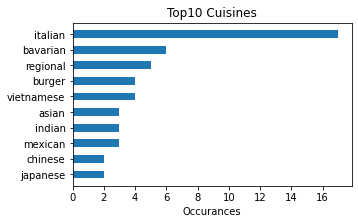

In [4]:
top10_cuisines = pd.read_sql('''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 10;
''', conn)

import matplotlib.pyplot as plt
top10_cuisines.sort_values('num', ascending = True, inplace = True)
plt.figure(figsize=(5,3)) 
plt.barh(top10_cuisines['value'], top10_cuisines['num'], height = 0.5);
plt.title("Top10 Cuisines");
plt.xlabel("Occurances");

#### Religions
How is the distribution of places of worship per religion?

In [34]:
religions = pd.read_sql('''
SELECT ways_tags.value, COUNT(*) as num
FROM ways_tags
    JOIN (SELECT DISTINCT(id) FROM ways_tags WHERE value='place_of_worship') a
    ON ways_tags.id=a.id
WHERE ways_tags.key='religion'
GROUP BY ways_tags.value
ORDER BY num DESC;
''', conn)

religions

,value,num
0,christian,28


### Verify the cleaning process
#### Non-Munich city tags
Let's check if some city tags other than "München" made it through the cleaning process

In [35]:
city_count = pd.read_sql('''
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) tags
WHERE tags.key = 'city'
GROUP BY tags.value
ORDER BY count DESC;
''', conn)

city_count

,value,count
0,München,5375
1,Pullach i. Isartal,75
2,Neuried,51
3,Planegg,15
4,Unterhaching,13
5,Vaterstetten,6
6,Haar,6
7,Karlsfeld,5
8,Freising,5
9,Schäftlarn,4


Unfortunately yes. In this case we are interested to know the corresponding postalcodes as a means to check if it is due to a wrong city tag or if also the postcodes do not belong to Munich.

First we make a join of nodes_tags and ways_tags because both tables contain postcodes, one written as "postal_code" and one as "postcode". This list then contains all unique ids with their respective postcodes.

In [36]:
postcodes = pd.read_sql('''
SELECT *
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code'
ORDER BY id DESC
''', conn)

postcodes

,id,key,value,type
0,8409759817,postcode,80333,addr
1,8390937133,postcode,81929,addr
2,8387676430,postcode,81825,addr
3,8344361561,postcode,81247,addr
4,8318234972,postcode,80799,addr
...,...,...,...,...
5271,4056251,postal_code,82544,regular
5272,3994252,postal_code,81827,regular
5273,3810642,postal_code,80331,regular
5274,3551855,postal_code,81827,regular


In second step we query the list of Non-Munich city tags for every unique id. There are overall 218 Elements that have a Non-Munich city tag and therefore do not belong in the database.

In [37]:
city_tags_not_munich = pd.read_sql('''
SELECT *
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
WHERE ctags.key = 'city' and ctags.value NOT LIKE 'München%'
ORDER BY id DESC
''', conn)
city_tags_not_munich

,id,key,value,type
0,8151799240,city,Haar,addr
1,6766546156,city,Unterhaching,addr
2,4972791851,city,Schäftlarn,addr
3,4891956792,city,Fürstenfeldbruck,addr
4,4833377402,city,Gilching,addr
...,...,...,...,...
214,43341084,city,Grasbrunn,addr
215,41930634,city,Neuried,addr
216,40815885,city,Neuried,addr
217,38751874,city,Freising,addr


In third step we want to join these lists in order to receive the adresses of the non-munich city tags

In [38]:
city_tags_not_munich_joined_with_postcode_tags = pd.read_sql('''
SELECT *
FROM (SELECT ptags.id, ptags.value postcode, ptags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
      WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code') postcodes
JOIN (SELECT ctags.id, ctags.value city, ctags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
      WHERE ctags.key = 'city' and ctags.value NOT LIKE 'München%') cities
ON postcodes.id = cities.id
''', conn)

city_tags_not_munich_joined_with_postcode_tags

,id,postcode,key,id,city,key
0,1280387631,82049,postal_code,1280387631,Pullach i. Isartal,city


Oh no, why does this only return one result? 
The explanation for this is that all the element ids with non-munich city tags have no postcodes assigned. During cleaning in Python only the elements with postcodes not being in the expected postcode list were sorted out. But we did not consider the case that there might be elements that don't come with a postcode tag. That is why these elements were missed during cleaning.

But why do we have one result then?
This is because it has been forgotten in the cleaning that there are apparently some elements which have the key "postal_code" instead of "postcode". Since this inconsistency has not been considered this is the reason why this element is still in the database.

As a cross-check we query once more the Non-Munich city tags but this time as LEFT JOIN so we get all Non-Munich city tags and not only the ones matching a postcode like previously. They should all return "None" but the one result with the key 'postal_code'.

In [39]:
city_tags_not_munich_joined_with_postcode_tags = pd.read_sql('''
SELECT *
FROM (SELECT ctags.id, ctags.value city
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
      WHERE ctags.key = 'city' and ctags.value NOT LIKE 'München%') cities
LEFT JOIN (SELECT ptags.id, ptags.value postcode
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
      WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code') postcodes
ON postcodes.id = cities.id
LIMIT 213;
''', conn)

pd.set_option('display.max_rows', 213)
city_tags_not_munich_joined_with_postcode_tags

,id,city,id,postcode
0,110357017,Neuried,NaN,None
1,471799591,Unterhaching,NaN,None
2,472050815,Unterhaching,NaN,None
3,472445888,Neuried,NaN,None
4,476029437,Unterhaching,NaN,None
5,476029517,Unterhaching,NaN,None
6,479509638,Unterhaching,NaN,None
7,628598549,Garching bei München,NaN,None
8,642094255,Neuried,NaN,None
9,712613849,Neubiberg,NaN,None


Exactly, all but one return 'None'. Only the one result we had previously.

#### Solving the problems
1) The first issue, which is some missed city tags that do not belong to Munich we just solve by deleting all rows where the city keys are not 'München'

In [40]:
sqlite_file = 'osm.db'

conn = sqlite3.connect(sqlite_file)

cur = conn.cursor()

cur.execute(''' 
DELETE FROM nodes_tags WHERE key = 'city' and value != 'München';
''')
conn.commit()

cur.execute(''' 
DELETE FROM ways_tags WHERE key = 'city' and value != 'München';
''')
conn.commit()

2) Second issue where there is one row not belonging to Munich with key 'postal_code. We delete the rows where city keys are not 'München' and where key is 'postal_code'. Hereby all rows of the element are thoroughly deleted in the database.

In [41]:
sqlite_file = 'osm.db'

conn = sqlite3.connect(sqlite_file)

cur = conn.cursor()

cur.execute(''' DELETE FROM nodes_tags
WHERE id = '1280387550';''')
conn.commit()

#### Continuing with investigation on postcodes for correct 'Munich' city tags

Do we also have some 'postal_code' tags in the elements correctly beloning to Munich? Let's query that:

In [42]:
city_tags_not_munich_joined_with_postcode_tags = pd.read_sql('''
SELECT *
FROM (SELECT ptags.id, ptags.value postcode, ptags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
      WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code') postcodes
JOIN (SELECT ctags.id, ctags.value city, ctags.key
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
      WHERE ctags.key = 'city' and ctags.value LIKE 'München%') cities
ON postcodes.id = cities.id
WHERE postcodes.key = 'postal_code'
''', conn)

city_tags_not_munich_joined_with_postcode_tags

,id,postcode,key,id,city,key
0,2450480057,80469,postal_code,2450480057,München,city
1,2450480082,80469,postal_code,2450480082,München,city


Yes, there are two result. So we can see that there are much fewer cases with 'postal_code' tags but they exist.

Do we encounter the same problem of missing postcode tags also for elements with correct 'Munich' city tags?
When we make a LEFT JOIN on the IDs of elements with city key 'Munich' where postcode is "Null" this should return all "None" entries in the postcode column.

In [43]:
city_tags_not_munich_joined_with_postcode_tags = pd.read_sql('''
SELECT *
FROM (SELECT ctags.id, ctags.value city
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ctags
      WHERE ctags.key = 'city' and ctags.value LIKE 'München%') cities
LEFT JOIN (SELECT ptags.id, ptags.value postcode
      FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) ptags
      WHERE ptags.key = 'postcode' OR ptags.key = 'postal_code') postcodes
ON postcodes.id = cities.id
WHERE postcode IS NULL;
''', conn)

city_tags_not_munich_joined_with_postcode_tags

,id,city,id,postcode
0,290528076,München,None,None
1,305975454,München,None,None
2,311151782,München,None,None
3,411896077,München,None,None
4,412264636,München,None,None
...,...,...,...,...
773,289891351,München,None,None
774,302322325,München,None,None
775,329675293,München,None,None
776,345116005,München,None,None


There are 778 Null values. Which means elements that have a correct city tag but miss a postcode tag. 

What do we do about these too issues? Nothing. Although it is inconsistent data these are still valid entries.

#### Verify phone numbers

In [44]:
phone_numbers = pd.read_sql('''
SELECT tags.value
FROM (SELECT * FROM nodes_tags UNION 
      SELECT * FROM ways_tags) tags
WHERE tags.key = 'phone' and tags.value NOT LIKE '+49 ___ %';
''', conn)

phone_numbers

,value


No reslts. So everything seems to be clean here.